In [1]:
# Imports
import numpy as np
import requests
import pandas as pd
from data_classes import IncomeData
from os import makedirs, path, listdir, remove
from tqdm import tqdm
import zipfile as zpf
import matplotlib.pyplot as plt
import xlrd
from openpyxl import load_workbook
import wandb

In [2]:
income = IncomeData()

In [ ]:
url = "https://www.ons.gov.uk/file?uri=/economy/regionalaccounts/grossdisposablehouseholdincome/datasets/regionalgrossdisposablehouseholdincomebylocalauthoritiesbynuts1region/ukilondon/regionalgrossdisposablehouseholdincomelocalauthorityukilondon.xls"
income.download_and_log(url, "London")

In [162]:
df = income.read("income-raw")

In [175]:
df.shape

(22, 33)

#### Linear interpolation of annual data

In [ ]:
key = "D"
method = "linear"
linear_df = income.resample_time_and_log(key, method)

In [3]:
linear_df = income.read("income-resample")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: michellewl (use `wandb login --relogin` to force relogin)


In [9]:
linear_df.shape

(7671, 33)

In [27]:
rich_df = linear_df.loc[linear_df.index==linear_df.index.max()].transpose().nlargest(3, linear_df.index.max())

In [7]:
LAD_codes_df = income.read("income-metadata")

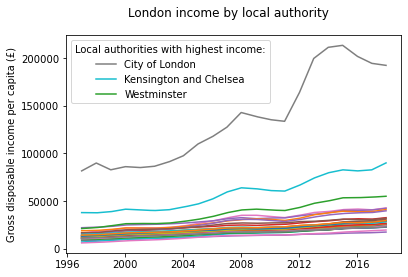

In [29]:
fig = plt.figure()

for LAD_code in linear_df.columns.to_list():
    if LAD_code in rich_df.index.to_list():
        plt.plot(linear_df[LAD_code], label=LAD_codes_df.loc[LAD_code].values[0])
    else:
        plt.plot(linear_df[LAD_code], label=None)
plt.legend(title="Local authorities with highest income:")
plt.ylabel("Gross disposable income per capita (£)")
plt.suptitle("London income by local authority")
plt.show()